# Imports

In [1]:
import random

import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler



from utils.data_utils import scale_data_per_country
from utils.model_utils import StackedLSTM, init_weights

# Data

In [2]:
def get_pd_from_pkl(path: str) -> pd.DataFrame:
    df = pd.read_pickle(path)
    return df
# df = get_pd_from_pkl(path=r"data\training_data\training_added_feats_no_hospital.pkl")
# df = get_pd_from_pkl(path=r"data\training_data\training_data_v1.0.pkl")
df = get_pd_from_pkl(path="data/training_data/training_datav2_0-weekly.pkl")
# df_policies = get_pd_from_pkl(path=r"data\all_policies\policies_individual_final.pkl")
# df_vaccines = get_pd_from_pkl(path=r"data\timeseries_pickles\additional_features\better_vaccine_data.pkl")
df_hospital = get_pd_from_pkl(path = r'data\timeseries_pickles\additional_features\weekly_hospital_data.pkl')

In [3]:
df_hospital

indicator,date,Weekly new ICU admissions,Weekly new ICU admissions per million,Weekly new hospital admissions,Weekly new hospital admissions per million,entity,iso_code
0,2020-04-19,184.000000,9.386000,579.600000,29.565800,Chile,CHL
1,2020-04-26,221.285714,11.287857,643.714286,32.836429,Chile,CHL
2,2020-05-03,211.714286,10.799429,846.142857,43.162571,Chile,CHL
3,2020-05-10,270.000000,13.773000,1382.714286,70.533429,Chile,CHL
4,2020-05-17,388.714286,19.828714,2158.857143,110.124714,Chile,CHL
...,...,...,...,...,...,...,...
2174,2022-12-04,198.428571,4.172143,3224.000000,67.790000,Spain,ESP
2175,2022-12-11,220.142857,4.629000,3291.000000,69.198857,Spain,ESP
2176,2022-12-18,221.285714,4.652857,3520.857143,74.031857,Spain,ESP
2177,2022-12-25,199.000000,4.184000,3214.142857,67.582714,Spain,ESP


In [4]:
print(df.columns)

feature_columns = ['C', 'G', 'S', 'new_cases']
info_columns = ['location', 'date']

used_columns = info_columns + feature_columns

Index(['location', 'date', 'weekly_cases', 'C', 'E', 'G', 'S',
       'biweekly_cases', 'biweekly_deaths', 'new_cases', 'new_deaths',
       'total_cases', 'total_deaths', 'weekly_deaths'],
      dtype='object')


# Build Classification

In [5]:
df_adapt  = df[used_columns].copy()
all_countries = df_adapt['location'].unique()   

df_adapt['policy'] = df_adapt[['C', 'G', 'S']].mean(axis=1)

bins = list(range(0, 101, 1))
labels = list(range(len(bins) - 1))
df_adapt['clf_policy'] = pd.cut(df_adapt['policy'], bins=bins, labels=labels, include_lowest=True, right=True)
df = df_adapt.copy()

In [6]:
# feature_columns = ['new_cases', 'C', 'E', 'G', 'S']
# info_columns = ['location', 'date']
# used_columns = feature_columns + info_columns


#especific per quan fem servir les dades de policies disgregagades
print(df.columns)
feature_columns = ['clf_policy']
info_columns = ['location', 'date']
target_column = 'clf_policy'
used_columns = feature_columns + info_columns

Index(['location', 'date', 'C', 'G', 'S', 'new_cases', 'policy', 'clf_policy'], dtype='object')


In [7]:
full_data = df[used_columns].fillna(0).copy()
# full_data = full_data[['location', 'C', 'E', 'G', 'S', 'weekly_deaths', 'weekly_cases']]
#per afegir noves features
# full_data = full_data[features]
full_data.loc[:, 'target'] = full_data[target_column]

# Filter out locations that appear less than 20 times
location_counts = full_data['location'].value_counts()
valid_locations = location_counts[location_counts >= 20].index
full_data = full_data[full_data['location'].isin(valid_locations)]

In [8]:
target_in_data = True
if not target_in_data:
    #TREURE LES NEW_CASES
    full_data = full_data.drop(columns=[target_column])
    feature_columns.remove(target_column)
feature_columns

['clf_policy']

In [9]:
random.seed(42)  # Set the random seed for reproducibility
target_country = random.sample(list(full_data.location.unique()), 8)
target_country = ['Spain']

In [10]:
train_data = full_data[~full_data['location'].isin(target_country)].copy()
test_data = full_data[full_data['location'].isin(target_country)].copy()

In [11]:
# feature_columns = ['C', 'E', 'G', 'S', 'weekly_deaths', 'weekly_cases']
feature_columns = feature_columns
target_column = "target"

#Get Train data

#Initialize scaler
scaler_X_train = MinMaxScaler()
scaler_y_train = MinMaxScaler()
y_train, X_train = scale_data_per_country(
                                    df=train_data, feature_columns=feature_columns,
                                    countries=list(train_data['location'].unique()),
                                    target_column=target_column, scaler=scaler_X_train
                                    )

#Get Test data
scaler_X_test = MinMaxScaler()
scaler_y_test = MinMaxScaler()
y_test, X_test = scale_data_per_country(
                                    df=test_data, feature_columns=feature_columns,
                                    countries=list(test_data['location'].unique()),
                                    target_column=target_column, scaler=scaler_y_test,
                                    seq_length=4
                                    )


# Training

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
def init_model(input_size:int, hidden_size:int, num_layers:int, output_size:int) -> nn.Module:
    """Instantiates the model and initializes weights.
    The model is a stacked LSTM with the specified input size, 
    hidden size, number of layers, and output size.

    Args:
        input_size (int): Input size to the LSTM layer.
        hidden_size (int): Hidden size of the LSTM layer.
        num_layers (int): Number of LSTM layers.
        output_size (int): Output size of the model.

    Returns:
        nn.Module: The initialized model.
    """
    model = StackedLSTM(input_size, hidden_size, num_layers, output_size)
    model.apply(init_weights)
    return model.to(device)

In [15]:
input_size= X_train.shape[2]
hidden_size=128
num_layers= 1
output_size=1
learning_rate=0.001
weight_decay = 1e-4

model = init_model(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize training parameters
num_epochs = 60 # Adjust as needed
print_every = 10  # Set how often to print

# Store losses
train_losses = []
val_losses = []  # This will now store RMSE on test set per epoch

# Start training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    # Only keep predictions and inputs from the last epoch
    if epoch == num_epochs - 1:
        predictions_last = []
        actuals_last = []
        inputs_last = []

    # Training loop
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if epoch == num_epochs - 1:
            predictions_last.extend(y_pred.cpu().detach().numpy())
            actuals_last.extend(y_batch.cpu().numpy())
            inputs_last.extend(X_batch.cpu().numpy())

    # Compute average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- RMSE Validation loop on test set ---
    model.eval()
    test_predictions = []
    test_actuals = []

    with torch.no_grad():
        for i in range(len(X_test_tensor)):
            X_val = X_test_tensor[i].unsqueeze(0).to(device)
            y_val = y_test_tensor[i].unsqueeze(0).to(device)

            y_pred = model(X_val)
            test_predictions.append(y_pred.cpu().numpy().flatten()[0])
            test_actuals.append(y_val.cpu().numpy().flatten()[0])

    # Compute RMSE as validation loss
    rmse_val = np.sqrt(mean_squared_error(test_actuals, test_predictions))
    val_losses.append(rmse_val)

    # Print losses
    if (epoch + 1) % print_every == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, RMSE (Test): {rmse_val:.4f}")


Epoch [10/60] - Train Loss: 0.0028, RMSE (Test): 0.0494
Epoch [20/60] - Train Loss: 0.0023, RMSE (Test): 0.0458
Epoch [30/60] - Train Loss: 0.0022, RMSE (Test): 0.0461
Epoch [40/60] - Train Loss: 0.0021, RMSE (Test): 0.0455
Epoch [50/60] - Train Loss: 0.0021, RMSE (Test): 0.0454
Epoch [60/60] - Train Loss: 0.0021, RMSE (Test): 0.0455


In [17]:
model.eval()
train_predictions = []
train_actuals = []

with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(X_batch)
        train_predictions.append(y_pred.cpu())
        train_actuals.append(y_batch.cpu())

# Convert to tensors or numpy
train_predictions = torch.cat(train_predictions).numpy()
train_actuals = torch.cat(train_actuals).numpy()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import json
import os
import matplotlib.pyplot as plt

# Convert to numpy arrays
preds = np.array(test_predictions)
actuals = np.array(test_actuals)

# Compute metrics
mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))
r2 = r2_score(actuals, preds)

print(f"\nTest Country Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# Save metrics
test_country = target_country  # or whatever test country you're working with
metrics = {
    "country": test_country,
    "mae": mae,
    "rmse": rmse,
    "r2": r2
}

# os.makedirs("results", exist_ok=True)
# with open(f"results/metrics_{test_country}.json", "w") as f:
#     json.dump(metrics, f, indent=4)



Test Country Metrics:
MAE: 0.0215
RMSE: 0.0455
R2 Score: 0.9623


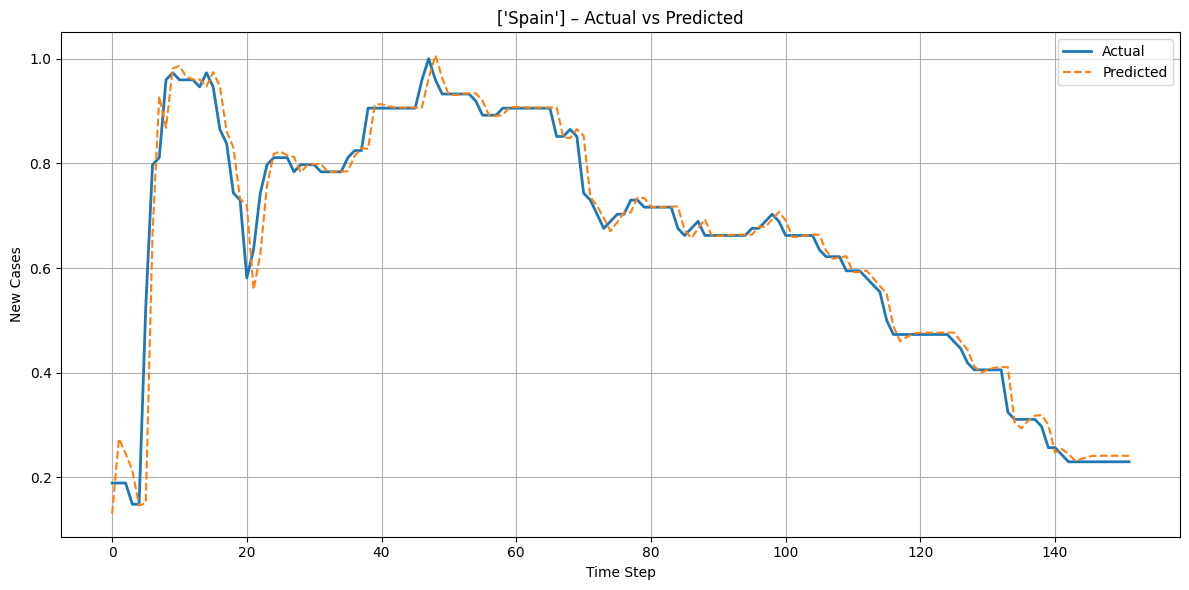

In [19]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual', linewidth=2)
plt.plot(preds, label='Predicted', linestyle='--')
plt.title(f"{test_country} – Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"results/prediction_plot_{test_country}.png")
plt.show()